In [1]:
from sigvisa.treegp.gp import GPCov, GP, prior_sample, mcov
import pyublas


In [2]:
y = np.array([4, 4, 0])
X_obs = np.array([-1, 0, 1], dtype=np.float64)
x_obs_var = np.array([1,1,1])
y_obs_var = 0.1
cov = GPCov(wfn_params=[1.0,], wfn_str="se", dfn_params=[1.0,], dfn_str="euclidean")

print X_obs

import scipy.stats
def ll(X):
    K = mcov(X.reshape(-1, 1), cov, y_obs_var)
    gpll = scipy.stats.multivariate_normal(mean=np.zeros(y.shape), cov=K).logpdf(y)
    x_obs_ll = 0
    for i in range(len(X)):
        x_obs_ll += scipy.stats.norm(loc=X[i], scale=np.sqrt(x_obs_var[i])).logpdf(X_obs[i])
    return gpll + x_obs_ll

[-1.  0.  1.]


In [3]:
# TODO1: run MCMC on this likelihood to find true X posterior

def mh_step(ll_old, X, std=0.4):
    r = np.random.randn(len(X)) * std
    X_new = X+r
    ll_new = ll(X_new)
    u = np.random.rand()
    if ll_new-ll_old > np.log(u):
        return X_new, ll_new, True
    else:
        return X, ll_old, False

def mh(X, steps=10000):
    lls = []
    Xs = []
    accepts = []
    cll = ll(X)
    for step in range(steps):
        X, cll, accept = mh_step(cll, X)
        Xs.append(X)
        lls.append(cll)
        accepts.append(accept)
        if step%50==0:
            print "step %d, accept rate %f, lp %f" % (step, np.mean(accepts), cll)
    return np.array(Xs), np.array(lls)



In [57]:
mhXs, mhlls = mh(X_obs)

step 0, accept rate 1.000000, lp -16.776343
step 50, accept rate 0.450980, lp -16.572389
step 100, accept rate 0.455446, lp -17.220406
step 150, accept rate 0.450331, lp -15.793003
step 200, accept rate 0.407960, lp -21.695242
step 250, accept rate 0.426295, lp -14.156467
step 300, accept rate 0.415282, lp -14.074741
step 350, accept rate 0.401709, lp -16.032235
step 400, accept rate 0.391521, lp -15.799806
step 450, accept rate 0.394678, lp -13.930408
step 500, accept rate 0.413174, lp -13.453839
step 550, accept rate 0.415608, lp -12.876384
step 600, accept rate 0.424293, lp -13.865612
step 650, accept rate 0.420891, lp -12.910761
step 700, accept rate 0.419401, lp -15.760094
step 750, accept rate 0.423435, lp -15.215407
step 800, accept rate 0.425718, lp -14.228236
step 850, accept rate 0.423032, lp -14.960756
step 900, accept rate 0.417314, lp -15.233854
step 950, accept rate 0.421661, lp -16.848188
step 1000, accept rate 0.419580, lp -13.733281
step 1050, accept rate 0.419600, lp 

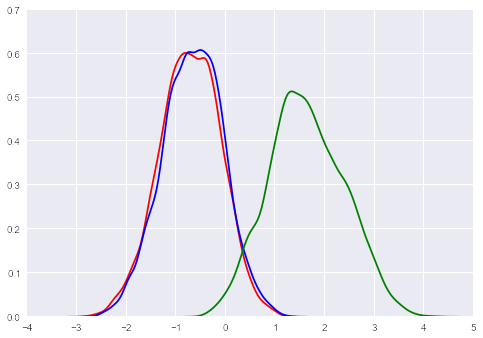

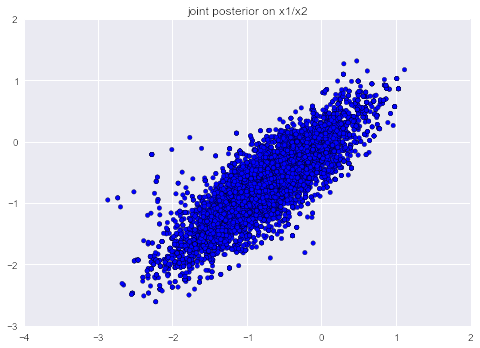

In [53]:
np.mean(mhXs[200:], axis=0)

import seaborn as sns

sns.kdeplot(mhXs[200:,0], color="red")
sns.kdeplot(mhXs[200:,1], color="blue")
sns.kdeplot(mhXs[200:,2], color="green")

figure()
scatter(mhXs[200:,0], mhXs[200:,1])
title("joint posterior on x1/x2")

# Integrated covariances for uncertain inputs

In [50]:
# question is: say we have three inputs with uncertain locations. define a random variable 
# which is the observation at the true input location. what are the covairnaces of these random vairbales?

def integrated_cov_matrix(x_means, x_vars, lengthscale=1.0):
    n = len(x_means)
    cov=np.zeros((n,n))
    dcov=np.zeros((n,n))
    for i in range(n):
        cov[i,i]=1.0
        dcov[i,i] = 0.0
        for j in range(i+1,n):
            r = x_means[i]-x_means[j]
            cov[i,j] = np.exp(-.5*r*r/(x_vars[i]+x_vars[j]+lengthscale))
            cov[j,i] = cov[i,j]
            
            dcov[i,j] = cov[i,j] * -1.0/(x_vars[i]+x_vars[j]+lengthscale)
            
    return cov, dcov



# iterative algorithm: start by learning a function from the starting beliefs on X.
# next, use this to find a new posterior on the X's. 
# okay wait. I can certainly use the function from two x's to find the point x that 
# conditionally maximizes the posterior on the third x. 
# I could also ignore the whole integration over covariances entirely, and just optimize 
# the locations of the x's under the usual point covariance. 
# or I could optimize the 'belief' (mean, covariance) on the x's under the LL of the 
# integrated cov function. 
# how does this work out? it'd be something like the normalizing constant of multiplying the two gaussians. 

def beliefnll(xmeansvars):
    n = len(xmeansvars)/2
    xmeans = xmeansvars[:n]
    xvars = xmeansvars[n:]**2
    cov, dcov = integrated_cov_matrix(xmeans, xvars)
    try:
        gpll = scipy.stats.multivariate_normal(mean=np.zeros(y.shape), cov=cov).logpdf(y)
    except ValueError:
        return np.inf
    x_obs_ll = 0
    for i in range(n):
        x_obs_ll += scipy.stats.norm(loc=xmeans[i], scale=np.sqrt(x_obs_var[i]+xvars[i])).logpdf(X_obs[i])
    ll = -(gpll + x_obs_ll)
    return ll

x0 = np.concatenate([X_obs, x_obs_var])
#print beliefnll(x0)
r = scipy.optimize.minimize(beliefnll, x0)
print r


[-1.  0.  1.] [ 1.  1.  1.] 45.0571109081
[-0.99999999  0.          1.        ] [ 1.  1.  1.] 45.057111293
[ -1.00000000e+00   1.49011612e-08   1.00000000e+00] [ 1.  1.  1.] 45.0571120556
[-1.          0.          1.00000001] [ 1.  1.  1.] 45.0571093757
[-1.  0.  1.] [ 1.00000003  1.          1.        ] 45.0571105757
[-1.  0.  1.] [ 1.          1.00000003  1.        ] 45.0571124911
[-1.  0.  1.] [ 1.          1.          1.00000003] 45.0571109582
[-1.  0.  1.] [ 1.  1.  1.] 45.0571109081
[ -26.83286238  -77.00753307  103.84036255] [  5.43323131e+02   1.10736905e+04   5.56906948e+00] 827.754498353
[ -26.83286238  -77.00753307  103.84036255] [  5.43323131e+02   1.10736905e+04   5.56906948e+00] 827.754498353
[ -26.83286236  -77.00753307  103.84036255] [  5.43323131e+02   1.10736905e+04   5.56906948e+00] 827.754498353
[ -26.83286238  -77.00753306  103.84036255] [  5.43323131e+02   1.10736905e+04   5.56906948e+00] 827.754498353
[ -26.83286238  -77.00753307  103.84036256] [  5.43323131e+02 

In [48]:
print r

NameError: name 'r' is not defined

# Variational inference

In [4]:
from sigvisa.models.spatial_regression.gp_uncertain_inputs_variational import UncertainInputGP, cov_matrix, compute_Psi1, compute_Psi2

In [5]:
p_means = [np.array((-1.0,)), np.array((0.0,)), np.array((1.0,))]
p_covs = [np.array(((1.0,),)), np.array(((1.0,),)), np.array(((1.0,),))]
theta = np.array([1.0, 1.0])

Y = np.array(((4,), (4,), (0,)))

Xu = np.array((-1, 0, 1)).reshape((-1, 1))

sigma2_n=0.1

# Psi1 is expectation of K_xu under q(x)
# so it should be equal to the actual cov if we set variances to zero
p_covs_zero = [np.array(((0.0,),)), np.array(((0.0,),)), np.array(((0.0,),))]
P1 = compute_Psi1(p_means, p_covs_zero, Xu, theta)
C = cov_matrix(np.array(p_means).reshape(-1, 1), Xu, theta)
print P1-C

# similarly we can test Psi2
P2 = compute_Psi2(p_means, p_covs_zero, Xu, theta)
print P2- np.dot(C.T, C)



[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


In [6]:
uigp = UncertainInputGP(p_means, p_covs, Y)
xm, xv = uigp.locate_inputs(Xu, theta, sigma2_n)
print xm
print xv

In [30]:
# more interesting setup: 2d world, a line? of events, and let's say a 5d output space
# 
sigma2_n = 0.01
true_X = np.array(( (-2.0, 0.0),\
                    (-1.0, 0.0),\
                    (0.0, 0.0),\
                    (1.0, 0.0),\
                    (2.0, 0.0),))

n = true_X.shape[0]
theta = np.array([1.0, 5.0, 5.0])
C = cov_matrix(true_X, true_X, theta) + sigma2_n*np.eye(n)
ys = scipy.stats.multivariate_normal(mean=np.zeros((n,)), cov=C).rvs(5).T

obs_x = [x+np.random.randn(2) for x in true_X]
obs_cov = [np.eye(2) for x in true_X]

Xu = true_X


In [31]:
uigp = UncertainInputGP(obs_x, obs_cov, ys)
xm, xv = uigp.locate_inputs(Xu, theta, sigma2_n)
print xm
print xv

[array([-2.83819222,  0.01406575]), array([-1.56633269, -0.01230314]), array([-0.03980717,  0.00176146]), array([ 1.05955261,  0.01673383]), array([  2.69217188e+00,  -7.91085500e-04])]
[array([[  1.44473665e-02,   3.36474559e-05],
       [  3.36474559e-05,   9.87133459e-03]]), array([[  1.60018699e-02,  -2.09816840e-05],
       [ -2.09816840e-05,   9.77129861e-03]]), array([[  2.37739141e-02,   1.01793999e-05],
       [  1.01793999e-05,   9.69323175e-03]]), array([[  1.63212855e-02,  -7.34939392e-05],
       [ -7.34939392e-05,   9.88314264e-03]]), array([[  1.63352786e-02,  -2.48150965e-05],
       [ -2.48150965e-05,   9.91976109e-03]])]
